<a href="https://colab.research.google.com/github/DaiVo20/Question-answering-in-BoolQ/blob/main/transformer_muppet_roberta_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install and import library**

In [1]:
!pip install -Uqq transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 33.3 MB/s 
     |████████████████████████████████| 61 kB 483 kB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.0 MB/s 


In [2]:
!pip install -Uqq datasets

     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 44.2 MB/s 
     |████████████████████████████████| 243 kB 34.6 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 192 kB 41.5 MB/s 
     |████████████████████████████████| 160 kB 40.0 MB/s 
     |████████████████████████████████| 271 kB 38.2 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import random
import torch
import time
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

# **Load data**

In [5]:
from google.colab import drive
drive._mount('/content/drive')

path_model = os.path.join('/content/drive/MyDrive/Colab/XuLyNgonNguTuNhien/DoAn', 'muppet-roberta-base.pt')

Mounted at /content/drive


In [6]:
dataset = load_dataset('boolq')

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
train_data = pd.DataFrame(dataset['train'])
dev_data = pd.DataFrame(dataset['validation'])
data = pd.concat([train_data, dev_data], ignore_index=True)

In [8]:
data

,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,False,As with other games in The Elder Scrolls serie...
...,...,...,...
12692,is manic depression the same as bi polar,True,"Bipolar disorder, previously known as manic de..."
12693,was whiskey galore based on a true story,True,SS Politician was an 8000-ton cargo ship owned...
12694,are there plants on the international space st...,True,Plant research continued on the International ...
12695,does the hockey puck have to cross the line to...,True,"In ice hockey, a goal is scored when the puck ..."


In [9]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# **Prepare data**

In [10]:
passages_train = train_data['passage'].values
questions_train = train_data['question'].values
answers_train = train_data['answer'].values.astype(int)

passages_test = test_data['passage'].values
questions_test = test_data['question'].values
answers_test = test_data['answer'].values.astype(int)

passages_dev = dev_data['passage'].values
questions_dev = dev_data['question'].values
answers_dev = dev_data['answer'].values.astype(int)

# **Train model**

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("facebook/muppet-roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("facebook/muppet-roberta-base")
model.to(DEVICE)

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/muppet-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at facebook/muppet-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.de

In [12]:
def encode_data(tokenizer, questions, passages, max_length):
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [13]:
# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)
input_ids_test, attention_masks_test = encode_data(tokenizer, questions_test, passages_test, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)
test_features = (input_ids_test, attention_masks_test, answers_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [14]:
batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
test_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in test_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
test_dataset = TensorDataset(*test_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [ ]:
epochs = 10
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for epoch in tqdm(range(epochs), desc="Epoch"):
    # Training
    start = time.perf_counter()
    epoch_train_loss = 0
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2].to(DEVICE)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
        
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)
    
    # Evaluation
    epoch_dev_accuracy = 0
    model.eval()

    for batch in dev_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

    end = time.perf_counter()
    print(f'Epoch {epoch + 1}/{epochs}\tTrain loss: {epoch_train_loss:.4f}\tDev accuracy: {epoch_dev_accuracy:.4f}')
    print(f'Time: {end - start:.2f}s')
    
print('Finished training!')

Epoch:  10%|█         | 1/10 [13:45<2:03:46, 825.19s/it]

Epoch 1/10	Train loss: 0.4128	Dev accuracy: 0.8411
Time: 825.18s


Epoch:  20%|██        | 2/10 [27:31<1:50:06, 825.84s/it]

Epoch 2/10	Train loss: 0.2917	Dev accuracy: 0.8575
Time: 826.30s


Epoch:  30%|███       | 3/10 [41:17<1:36:21, 825.90s/it]

Epoch 3/10	Train loss: 0.2088	Dev accuracy: 0.8563
Time: 825.97s


Epoch:  40%|████      | 4/10 [55:03<1:22:36, 826.02s/it]

Epoch 4/10	Train loss: 0.1546	Dev accuracy: 0.8532
Time: 826.19s


Epoch:  50%|█████     | 5/10 [1:08:50<1:08:51, 826.29s/it]

Epoch 5/10	Train loss: 0.1221	Dev accuracy: 0.8489
Time: 826.78s


Epoch:  60%|██████    | 6/10 [1:22:36<55:04, 826.25s/it]  

Epoch 6/10	Train loss: 0.0979	Dev accuracy: 0.8512
Time: 826.15s


Epoch:  70%|███████   | 7/10 [1:36:22<41:18, 826.02s/it]

Epoch 7/10	Train loss: 0.0969	Dev accuracy: 0.8544
Time: 825.54s


Epoch:  80%|████████  | 8/10 [1:50:07<27:31, 825.87s/it]

Epoch 8/10	Train loss: 0.0740	Dev accuracy: 0.8501
Time: 825.55s


Epoch:  90%|█████████ | 9/10 [2:03:54<13:46, 826.01s/it]

Epoch 9/10	Train loss: 0.0687	Dev accuracy: 0.8524
Time: 826.32s


Epoch: 100%|██████████| 10/10 [2:17:39<00:00, 825.94s/it]

Epoch 10/10	Train loss: 0.0637	Dev accuracy: 0.8524
Time: 825.38s
Finished training!


# **Save and load model**

In [ ]:
torch.save(model, path_model)

In [15]:
model = torch.load(path_model)

# **Evaluate model**

In [16]:
# Evaluation on dev set
num_classes = 2
model.eval()

y_true_dev = []
y_pred_dev = []

with torch.no_grad():
    for batch in dev_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]
    
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        y_true_dev = np.concatenate((y_true_dev, labels))
        y_pred_dev = np.concatenate((y_pred_dev, predictions))

print("Accuracy on dev: {:.4f}".format(accuracy_score(y_true_dev, y_pred_dev)))

Accuracy on dev: 0.8520


In [ ]:
# Evaluation on test set
test_accuracy = 0
num_classes = 2
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    confusion_matrix = torch.zeros(num_classes, num_classes)
    for batch in test_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]
    
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, predictions))
        
        test_accuracy += np.sum(predictions == labels) / len(labels)
        
        for t, p in zip(labels, predictions):
            confusion_matrix[t, p] += 1

    test_accuracy = test_accuracy / len(test_dataloader)
    print('Accuracy:', test_accuracy)
    print('Confusion maxtrix:\n', confusion_matrix)

Accuracy: 0.8453835227272727
Confusion maxtrix:
 tensor([[409.,  87.],
        [110., 664.]])


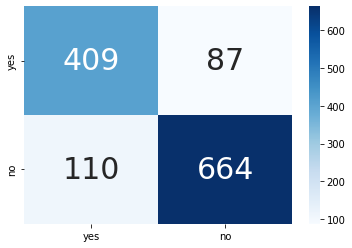

In [ ]:
labels = ['yes', 'no']
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.clf()
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
#@title
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Accuracy: {:.4f}".format(acc))
print("F1: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.8449
F1: 0.8708
Precision: 0.8842
Recall: 0.8579


# **Predict**

In [ ]:
def predict(question, passage):
    with torch.no_grad():
        encoded_data = tokenizer.encode_plus(question, passage,
                                            max_length=max_seq_length,
                                            pad_to_max_length=True,
                                            add_special_tokens=True,
                                            return_token_type_ids=False,
                                            return_attention_mask=True,
                                            return_tensors='pt',)
        input_id = encoded_data["input_ids"].to(DEVICE)
        attention_mask = encoded_data["attention_mask"].to(DEVICE)

        output = model(input_id, token_type_ids=None, attention_mask=attention_mask)
        _, prediction = torch.max(output[0], dim=1)
        return True if prediction.cpu().numpy()[0] else False

In [ ]:
data_point = test_data.sample().values[0]
question = data_point[0]
passage = data_point[2]
answer_true = data_point[1]

In [ ]:
print("Question:", question)
print("Passage:", passage)
print("Answer:", answer_true)

Question: tnt is an example of a high explosive
Passage: The velocity with which the reaction process propagates in the mass of the explosive. Most commercial mining explosives have detonation velocities ranging from 1800 m/s to 8000 m/s. Today, velocity of detonation can be measured with accuracy. Together with density it is an important element influencing the yield of the energy transmitted for both atmospheric over-pressure and ground acceleration. By definition, a ``low explosive,'' such as black powder, or smokeless gunpowder has a burn rate of 171--631 m/s. In contrast, a ``high explosive,'' whether a primary, such as detonating cord, or a secondary, such as TNT or C-4 has a significantly higher burn rate.
Answer: True


In [ ]:
result = predict(question, passage)
print("Predict:", result)

Predict: True
